# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.functions import isnan, when, count, col
from pyspark.sql import Window
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.feature import Normalizer
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, RegressionEvaluator
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [2]:
# create a Spark session
spark = SparkSession \
        .builder \
        .appName("Sparkify") \
        .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
#Loading data
path = "mini_sparkify_event_data.json"
mini_sparkify = spark.read.json(path)

In [4]:
mini_sparkify.take(5)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

In [5]:
mini_sparkify_describe = mini_sparkify.describe().toPandas()

In [6]:
#calculate missing values for columns in mini_sparkify
null_percentage = (mini_sparkify_describe.iloc[0,1:].astype(np.int).max()-mini_sparkify_describe.iloc[0,1:].astype(np.int)) \
/mini_sparkify_describe.iloc[0,1:].astype(np.int).max()

In [7]:
null_percentage

artist           0.203812
auth             0.000000
firstName        0.029131
gender           0.029131
itemInSession    0.000000
lastName         0.029131
length           0.203812
level            0.000000
location         0.029131
method           0.000000
page             0.000000
registration     0.029131
sessionId        0.000000
song             0.203812
status           0.000000
ts               0.000000
userAgent        0.029131
userId           0.000000
Name: 0, dtype: float64

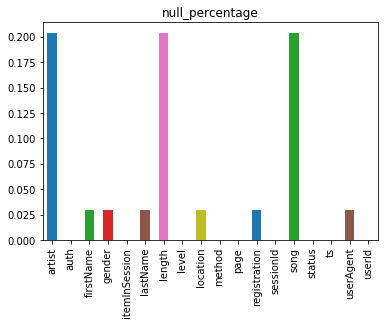

In [8]:
null_percentage.plot.bar(title = 'null_percentage')

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [9]:
# Check values for column "page"
mini_sparkify.select(mini_sparkify.page).drop_duplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
| Submit Registration|
|            Settings|
|               Login|
|            Register|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
+--------------------+
only showing top 20 rows



In [10]:
def add_Churn(df):
    """This function is to create a column Churn('Cancellation Confirmation') to use as the label for the model."""
    flag_cancellation = udf(lambda x: 1 if x =='Cancellation Confirmation' else 0, IntegerType())
    df = df.withColumn("Cancellation", flag_cancellation("page"))
    windowval = Window.partitionBy("userId").orderBy("ts").rangeBetween(Window.unboundedPreceding, 0)
    df = df.withColumn("Churn", Fsum("Cancellation").over(windowval))
    return df

In [11]:
mini_sparkify = add_Churn(mini_sparkify)

In [12]:
mini_sparkify_before_cancellation = mini_sparkify.filter(mini_sparkify["Churn"]==0)

In [13]:
mini_sparkify_before_cancellation.take(5)

[Row(artist='Sleeping With Sirens', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=202.97098, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Captain Tyin Knots VS Mr Walkway (No Way)', status=200, ts=1539003534000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', Cancellation=0, Churn=0),
 Row(artist='Francesca Battistelli', auth='Logged In', firstName='Darianna', gender='F', itemInSession=1, lastName='Carpenter', length=196.54485, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Beautiful_ Beautiful (Album)', status=200, ts=1539003736000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Ge

In [14]:
mini_sparkify_matrix1 = mini_sparkify['userId', 'Cancellation'].groupby('userId').sum()# matrix to indicate which user cancalled 

In [15]:
mini_sparkify_matrix1 = mini_sparkify_matrix1.withColumnRenamed('userId',"User")

In [16]:
mini_sparkify_matrix1.take(5)

[Row(User='100010', sum(Cancellation)=0),
 Row(User='200002', sum(Cancellation)=0),
 Row(User='125', sum(Cancellation)=1),
 Row(User='51', sum(Cancellation)=1),
 Row(User='124', sum(Cancellation)=0)]

In [17]:
cancel_percentage = mini_sparkify_matrix1[mini_sparkify_matrix1['sum(Cancellation)']==1].count()/mini_sparkify_matrix1.count()
stay_percentage = mini_sparkify_matrix1[mini_sparkify_matrix1['sum(Cancellation)']==0].count()/mini_sparkify_matrix1.count()

In [18]:
cancel_percentage

0.23008849557522124

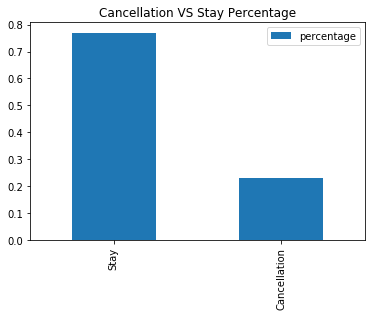

In [19]:
percentage = pd.DataFrame([stay_percentage, cancel_percentage],index  = ['Stay', 'Cancellation'], columns = ['percentage'])
percentage.plot.bar(title = 'Cancellation VS Stay Percentage')

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [20]:
def mini_sparkify_matrix(df):
    """This function is to create a matrix with necessary features for the model to modeling
    Input:
       The original data
    Output:
       The feature matrix for original data"""   
    flag_ThumbsDown = udf(lambda x: 1 if x =='Thumbs Down' else 0, IntegerType())
    flag_ThumbsUp = udf(lambda x: 1 if x =='Thumbs Up' else 0, IntegerType())
    flag_NextSong = udf(lambda x: 1 if x =='NextSong' else 0, IntegerType())
    flag_Playlist = udf(lambda x: 1 if x =='Add to Playlist' else 0, IntegerType())
    flag_Downgrade = udf(lambda x: 1 if x =='Submit Downgrade' else 0, IntegerType())
    df = df.withColumn("ThumbsDown", flag_ThumbsDown("page"))\
         .withColumn("ThumbsUp", flag_ThumbsUp("page"))\
         .withColumn("Songs_num", flag_NextSong("page"))\
         .withColumn("Playlist_songs", flag_Playlist("page"))\
         .withColumn("Downgrade", flag_Downgrade("page"))
    df_matrix = df.groupby('userId').sum()
    df_matrix = df_matrix.select(["userId", "sum(ThumbsDown)","sum(ThumbsUp)", "sum(Songs_num)","sum(Playlist_songs)","sum(Downgrade)"])
    df_matrix = df_matrix.withColumnRenamed("sum(ThumbsDown)","ThumbsDown")\
                .withColumnRenamed("sum(ThumbsUp)","ThumbsUp")\
                .withColumnRenamed("sum(Songs_num)","Total_songs")\
                .withColumnRenamed("sum(Playlist_songs)","Playlist_songs")\
                .withColumnRenamed("sum(Downgrade)","Downgrade")
    return df_matrix

In [21]:
mini_sparkify_matrix = mini_sparkify_matrix(mini_sparkify_before_cancellation)

In [22]:
# Add label column
mini_sparkify_matrix = mini_sparkify_matrix.join(mini_sparkify_matrix1, mini_sparkify_matrix.userId == mini_sparkify_matrix1.User,\
                                                 how='inner')

In [23]:
mini_sparkify_matrix = mini_sparkify_matrix.withColumnRenamed("sum(Cancellation)","Cancellation")

In [24]:
mini_sparkify_matrix = mini_sparkify_matrix.drop('User')

In [25]:
mini_sparkify_matrix.take(5)

[Row(userId='100010', ThumbsDown=5, ThumbsUp=17, Total_songs=275, Playlist_songs=7, Downgrade=0, Cancellation=0),
 Row(userId='200002', ThumbsDown=6, ThumbsUp=21, Total_songs=387, Playlist_songs=8, Downgrade=0, Cancellation=0),
 Row(userId='125', ThumbsDown=0, ThumbsUp=0, Total_songs=8, Playlist_songs=0, Downgrade=0, Cancellation=1),
 Row(userId='124', ThumbsDown=41, ThumbsUp=171, Total_songs=4079, Playlist_songs=118, Downgrade=0, Cancellation=0),
 Row(userId='51', ThumbsDown=21, ThumbsUp=100, Total_songs=2111, Playlist_songs=52, Downgrade=0, Cancellation=1)]

In [26]:
pd_mini_sparkify_matrix = mini_sparkify_matrix.toPandas()

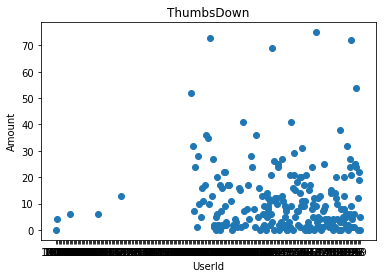

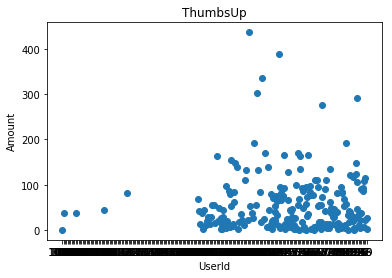

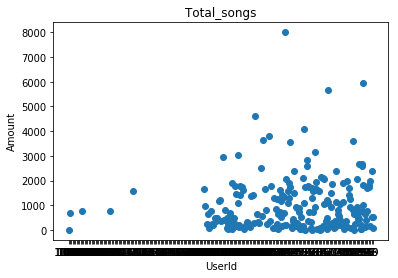

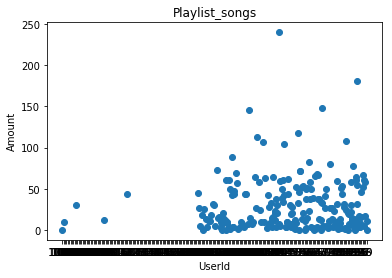

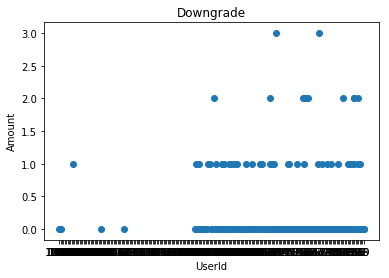

In [54]:
#plot value distribution for mini_sparkify_matrix
fig = plt.figure()
plt.scatter(pd_mini_sparkify_matrix['userId'].values,pd_mini_sparkify_matrix['ThumbsDown'].values)
plt.title('ThumbsDown')
plt.xlabel('UserId')
plt.ylabel('Amount')
fig1 = plt.figure()
plt.scatter(pd_mini_sparkify_matrix['userId'],pd_mini_sparkify_matrix['ThumbsUp'].values)
plt.title('ThumbsUp')
plt.xlabel('UserId')
plt.ylabel('Amount')
fig2 = plt.figure()
plt.scatter(pd_mini_sparkify_matrix['userId'],pd_mini_sparkify_matrix['Total_songs'].values)
plt.title('Total_songs')
plt.xlabel('UserId')
plt.ylabel('Amount')
fig3 = plt.figure()
plt.scatter(pd_mini_sparkify_matrix['userId'],pd_mini_sparkify_matrix['Playlist_songs'].values)
plt.title('Playlist_songs')
plt.xlabel('UserId')
plt.ylabel('Amount')
fig4 = plt.figure()
plt.scatter(pd_mini_sparkify_matrix['userId'],pd_mini_sparkify_matrix['Downgrade'].values)
plt.title('Downgrade')
plt.xlabel('UserId')
plt.ylabel('Amount')
fig5 = plt.figure()

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [28]:
# Split dataset for training model and testing model
train, test = mini_sparkify_matrix.randomSplit([0.6,0.2],seed=42) 

In [29]:
# Configure an ML pipeline, which consists of three stages: assembler, normalizer and (lr,rf,dt)
assembler = VectorAssembler(inputCols=['ThumbsDown', 'ThumbsUp', 'Total_songs','Playlist_songs', 'Downgrade'] ,\
                            outputCol="features")
normalizer = Normalizer(inputCol="features", outputCol="normFeatures",p=1)
lr = LogisticRegression(labelCol="Cancellation", featuresCol="normFeatures")# LogisticRegression model
rf = RandomForestClassifier(labelCol="Cancellation", featuresCol="normFeatures")# RandomForest model
dt = DecisionTreeClassifier(labelCol="Cancellation", featuresCol="normFeatures")# DecisionTree model
lr_pipeline = Pipeline(stages=[assembler,normalizer,lr])
rf_pipeline = Pipeline(stages=[assembler,normalizer,rf])
dt_pipeline = Pipeline(stages=[assembler,normalizer,dt])

In [30]:
# use ParamGridBuilder to construct a grid of parameters to search over
lr_paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.1, 0.5]) \
    .addGrid(lr.elasticNetParam, [0.1, 0.5]) \
    .build()
rf_paramGrid = ParamGridBuilder() \
    .addGrid(normalizer.p, [1, 2]) \
    .addGrid(rf.numTrees, [4, 20]) \
    .addGrid(rf.maxDepth, [5, 20]) \
    .build()
dt_paramGrid = ParamGridBuilder() \
    .addGrid(normalizer.p, [1, 2]) \
    .addGrid(dt.maxDepth, [10, 20])\
    .addGrid(dt.maxBins, [10, 20])\
    .build()
# use a CrossValidator including an Estimator, a set of Estimator ParamMaps and an Evaluator
lr_crossval = CrossValidator(estimator=lr_pipeline,
                          estimatorParamMaps=lr_paramGrid,
                          evaluator=MulticlassClassificationEvaluator(labelCol="Cancellation", predictionCol="prediction"),
                          numFolds=3)  
rf_crossval = CrossValidator(estimator=rf_pipeline,
                          estimatorParamMaps=rf_paramGrid,
                          evaluator=MulticlassClassificationEvaluator(labelCol="Cancellation", predictionCol="prediction"),
                          numFolds=3) 
dt_crossval = CrossValidator(estimator=dt_pipeline,
                          estimatorParamMaps=dt_paramGrid,
                          evaluator=MulticlassClassificationEvaluator(labelCol="Cancellation", predictionCol="prediction"),
                          numFolds=3)

In [31]:
# Run cross-validation, and choose the best set of parameters.
lrmodel = lr_crossval.fit(train)

In [41]:
rfmodel = rf_crossval.fit(train)

In [44]:
dtmodel = dt_crossval.fit(train)

In [51]:
# Run bestModel and get the best hyperparameters
lr_bestPipeline = lrmodel.bestModel
bestLRModel_2 = lr_bestPipeline.stages[2]
print('lr_bestParams: regParam: %s, elasticNetParam: %s ' %(bestLRModel_2.getOrDefault('regParam'), \
                                                            bestLRModel_2.getOrDefault('elasticNetParam')))

lr_bestParams: regParam: 0.1, elasticNetParam: 0.5 


In [52]:
rf_bestPipeline = rfmodel.bestModel
bestRFModel_1 = rf_bestPipeline.stages[1]
bestRFModel_2 = rf_bestPipeline.stages[2]
print('rf_bestParams: p-norm: %s, numTrees: %s, maxDepth: %s ' %(bestRFModel_1.getOrDefault('p'), bestRFModel_2.getOrDefault('numTrees'),\
      bestRFModel_2.getOrDefault('maxDepth')))

rf_bestParams: p-norm: 2.0, numTrees: 4, maxDepth: 20 


In [53]:
dt_bestPipeline = dtmodel.bestModel
bestDTModel_1 = dt_bestPipeline.stages[1]
bestDTModel_2 = dt_bestPipeline.stages[2]
print('dt_bestParams: p-norm: %s, maxDepth: %s, maxBins: %s ' %(bestDTModel_1.getOrDefault('p'), bestDTModel_2.getOrDefault('maxDepth'),\
      bestDTModel_2.getOrDefault('maxBins')))

dt_bestParams: p-norm: 2.0, maxDepth: 10, maxBins: 20 


In [46]:
def evaluate_model(model, test):
    """This function is to evaluate_model performance through F1 score"""
    predictions = model.transform(test)
    evaluator_f1 = MulticlassClassificationEvaluator(labelCol="Cancellation", predictionCol="prediction", metricName="f1")
    f1_score = evaluator_f1.evaluate(predictions)
    print("f1Score = %s" % (f1_score))
    return (f1_score)

In [47]:
lr_evaluate = evaluate_model(lrmodel, test)

f1Score = 0.7229036295369211


In [48]:
rf_evaluate = evaluate_model(rfmodel, test)

f1Score = 0.7145896656534955


In [49]:
dt_evaluate = evaluate_model(dtmodel, test)

f1Score = 0.7129959746981025


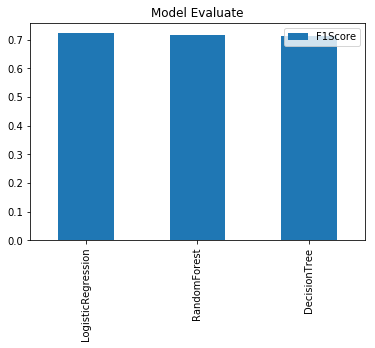

In [50]:
data = pd.DataFrame([lr_evaluate, rf_evaluate, dt_evaluate], index = ['LogisticRegression', 'RandomForest', 'DecisionTree'], \
                    columns = ['F1Score'])
data.plot.bar(title = 'Model Evaluate')

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.